In [1]:
# imports
from collections import defaultdict
import os
import torch
import random
import numpy as np
import pandas as pd
import json
import pickle
import gzip
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import glob
from rich import print as rprint
from rich.table import Table
from rich.console import Console
import datasets
from datasets import load_dataset

datasets.logging.set_verbosity_error()

In [43]:
def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


def save_pickle(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)
    
def ReadLineFromFile(path):
    lines = []
    with open(path,'r') as fd:
        for line in fd:
            lines.append(line.rstrip('\n'))
    return lines

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
def parse_2023(path):
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Parsing {path}"):
            yield json.loads(line)
        
'''
Set seeds
'''
seed = 2025
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


In [44]:
DATASET_DIR = "../dataset/amazon/2023/raw"
short_data_name = 'beauty'
os.makedirs(os.path.join(DATASET_DIR, short_data_name), exist_ok=True)

In [45]:
if short_data_name == 'beauty':
    full_data_name = 'Beauty'
elif short_data_name == 'toys':
    full_data_name = 'Toys_and_Games'
elif short_data_name == 'sports':
    full_data_name = 'Sports_and_Outdoors'
else:
    raise NotImplementedError


DATA_NAME_MAP = {
    'beauty': 'All_Beauty',
    'toys': 'Toys_and_Games',
    'sports': 'Sports_and_Outdoors'
}

INVERSE_DATA_NAME_MAP = {v: k for k, v in DATA_NAME_MAP.items()}

### For Sequential Recommendation

In [46]:
def display_pickle_summary(data, title="Pickle File Contents"):
    """
    Load and summarize the contents of a pickle file using rich.

    :param data: .pkl data
    :param title: Optional title for the printed table.
    """
    table = Table(title=title)
    
    table.add_column("Key/Type", style="cyan", no_wrap=True)
    table.add_column("Description", style="magenta")

    total_size = 0
    if isinstance(data, dict):
        for key, value in data.items():
            desc = f"{type(value).__name__}, len={len(value)}" if hasattr(value, '__len__') else type(value).__name__
            table.add_row(str(key), desc)
            if key in ["train", "test", "val"]:
                total_size += len(value)
            else:
                total_size = "N/A"
    else:
        table.add_row(type(data).__name__, f"{data}" if isinstance(data, (int, float, str)) else str(type(data)))

    table.add_row("Total Size", str(total_size))
    console = Console()
    console.print(table)
    
    if "train" in data or "test" in data or "val" in data:
        rprint("Train Sample:")
        rprint(data['train'][0])
        rprint("Val Sample:")
        rprint(data['val'][0])
        rprint("Test Sample:")
        print(data['test'][0])
        
        
def df_stats(df: pd.DataFrame, title="DataFrame Stats"):
    table = Table(title=title)
    rprint(f"DataFrame shape: {df.shape}")
    table.add_column("Column", style="cyan", no_wrap=True)
    table.add_column("Non-Null Count", style="yellow")
    table.add_column("Unique Count", style="magenta")
    table.add_column("Null/NA Count", style="red")
    table.add_column("Data Type", style="green")

    for col in df.columns:
        try:
            non_null_count = df[col].notna().sum()
        except:
            non_null_count = "Error"
        try:
            unique_count = df[col].nunique(dropna=True)
        except:
            unique_count = "Error"
        try:
            null_count = df[col].isna().sum()
        except:
            null_count = "Error"
        try:
            dtype = str(df[col].dtype)
        except:
            dtype = "Error"
        table.add_row(col, str(non_null_count), str(unique_count), str(null_count), dtype)

    Console().print(table)

In [47]:
def filter_amazon_dataset(category, metadata=False):
    rprint("Reading Ratings...")
    raw_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", 
                       f"raw_meta_{category}" if metadata else f"raw_review_{category}", 
                       trust_remote_code=True)
    raw_df = raw_dataset['full'].to_pandas()
    # df_stats(raw_df, f"{category} Reviews DataFrame Stats")
    
    rprint("Reading Ratings...")
    rating_file = hf_hub_download(
            repo_id='McAuley-Lab/Amazon-Reviews-2023',
            filename=f'benchmark/5core/rating_only/{category}.csv',
            repo_type='dataset'
            )
    rating_df = pd.read_csv(rating_file)
    # df_stats(rating_df, f"{category} Rating DataFrame Stats")
    
    # create sets for filtering
    valid_users = set(rating_df['user_id'].unique())
    valid_items = set(rating_df['parent_asin'].unique())
    
    rprint("Filtering Data...")
    # filter reviews where both user_id and parent_asin are in the 5-core subset
    if metadata:
        filtered_data = raw_df[raw_df['parent_asin'].isin(valid_items)]
    else:
        filtered_data = raw_df[
            (raw_df['user_id'].isin(valid_users)) & 
            (raw_df['parent_asin'].isin(valid_items))
        ]
    
    # df_stats(filtered_reviews, f"{category} Filtered Reviews DataFrame Stats")
    # rprint("Filtered Dataset Shape:", filtered_data.shape)
    
    return filtered_data

# return (user item timestamp) sort in get_interaction
def get_reviews(dataset_name, rating_score, year=2023):
    '''
    reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
    asin - ID of the product, e.g. 0000013714
    reviewerName - name of the reviewer
    helpful - helpfulness rating of the review, e.g. 2/3
    --"helpful": [2, 3],
    reviewText - text of the review
    --"reviewText": "I bought this for my husband who plays the piano. ..."
    overall - rating of the product
    --"overall": 5.0,
    summary - summary of the review
    --"summary": "Heavenly Highway Hymns",
    unixReviewTime - time of the review (unix time)
    --"unixReviewTime": 1252800000,
    reviewTime - time of the review (raw)
    --"reviewTime": "09 13, 2009"
    '''
    data = []
    # remove those with less than a certain score
    # older Amazon
    if not year == 2023:
        data_file = './raw_data/reviews_' + dataset_name + '.json.gz'
        for review in parse(data_file):
            if float(review['overall']) <= rating_score:
                continue
            user = review['reviewerID']
            item = review['asin']
            time = review['unixReviewTime']
            data.append((user, item, int(time)))
    # latest Amazon
    else:
        # slow to parse directly, load with HF
        data_file = os.path.join(DATASET_DIR, INVERSE_DATA_NAME_MAP[dataset_name], "reviews.json.gz")
        if not os.path.exists(data_file):
            # raise FileExistsError("Save the K-Core file first!")
            rprint(f"Saving the K-Core for `{dataset_name}` Reviews")
            # save the k-core first
            filtered_reviews = filter_amazon_dataset(dataset_name)
            filtered_reviews.to_json(data_file, 
                         orient='records', 
                         lines=True,
                         compression='gzip')
        for review in parse_2023(data_file):
            if float(review['rating']) <= rating_score:
                continue
            user = review['user_id']
            item = review['parent_asin']
            time = review['timestamp']
            data.append((user, item, int(time)))
            
    return data

def get_metadata(dataset_name, data_maps, year=2023):
    '''
    asin - ID of the product, e.g. 0000031852
    --"asin": "0000031852",
    title - name of the product
    --"title": "Girls Ballet Tutu Zebra Hot Pink",
    description
    price - price in US dollars (at time of crawl)
    --"price": 3.17,
    imUrl - url of the product image (str)
    --"imUrl": "http://ecx.images-amazon.com/images/I/51fAmVkTbyL._SY300_.jpg",
    related - related products (also bought, also viewed, bought together, buy after viewing)
    --"related":{
        "also_bought": ["B00JHONN1S"],
        "also_viewed": ["B002BZX8Z6"],
        "bought_together": ["B002BZX8Z6"]
    },
    salesRank - sales rank information
    --"salesRank": {"Toys & Games": 211836}
    brand - brand name
    --"brand": "Coxlures",
    categories - list of categories the product belongs to
    --"categories": [["Sports & Outdoors", "Other Sports", "Dance"]]
    '''
    data = {}
    item_asins = list(data_maps['item2id'].keys())

    # older Amazon
    if not year == 2023:
        meta_file = './raw_data/meta_' + dataset_name + '.json.gz'
        for info in parse(meta_file):
            if info['asin'] not in item_asins:
                continue
            data[info['asin']] = info
    # latest Amazon
    else:
        # slow to parse directly, load with HF
        meta_file = os.path.join(DATASET_DIR, INVERSE_DATA_NAME_MAP[dataset_name], "meta.json.gz")
        if not os.path.exists(meta_file):
            # raise FileExistsError("Save the K-Core file first!")
            rprint(f"Saving the K-Core for `{dataset_name}` Metadata")
            # save the k-core first
            filtered_meta = filter_amazon_dataset(dataset_name, metadata=True)
            filtered_meta.to_json(meta_file, 
                         orient='records', 
                         lines=True,
                         compression='gzip')
        for info in parse_2023(meta_file):
            # comparsion not required as filtered data is already correct
            # also, super slow parsing! need a better approach
            # if info['parent_asin'] not in item_asins:
            #     continue
            data[info['parent_asin']] = info
    return data

def add_comma(num):
    # 1000000 -> 1,000,000
    str_num = str(num)
    res_num = ''
    for i in range(len(str_num)):
        res_num += str_num[i]
        if (len(str_num)-i-1) % 3 == 0:
            res_num += ','
    return res_num[:-1]

# categories 和 brand is all attribute
def get_attribute_amazon(meta_infos, datamaps, attribute_core, year=2023):
    attributes = defaultdict(int)
    for iid, info in tqdm(meta_infos.items()):
        for cates in info['categories']:
            for cate in cates[1:]: # 把主类删除 没有用
                attributes[cate] +=1
        if year == 2023:
            brand = eval(info["details"]).get("Brand", "Unknown")
            attributes[brand] += 1
        else:
            attributes[info['brand']] += 1

    rprint(f'Before Delete, Attribute Num:{len(attributes)}')
    new_meta = {}
    for iid, info in tqdm(meta_infos.items()):
        new_meta[iid] = []

        if year == 2023:
            brand = eval(info["details"]).get("Brand", "Unknown")
            if attributes[brand] >= attribute_core:
                new_meta[iid].append(brand)
        else:
            if attributes[info['brand']] >= attribute_core:
                new_meta[iid].append(info['brand'])
                
        for cates in info['categories']:
            for cate in cates[1:]:
                if attributes[cate] >= attribute_core:
                    new_meta[iid].append(cate)
    # 做映射
    attribute2id = {}
    id2attribute = {}
    attributeid2num = defaultdict(int)
    attribute_id = 1
    items2attributes = {}
    attribute_lens = []

    for iid, attributes in new_meta.items():
        item_id = datamaps['item2id'][iid]
        items2attributes[item_id] = []
        for attribute in attributes:
            if attribute not in attribute2id:
                attribute2id[attribute] = attribute_id
                id2attribute[attribute_id] = attribute
                attribute_id += 1
            attributeid2num[attribute2id[attribute]] += 1
            items2attributes[item_id].append(attribute2id[attribute])
        attribute_lens.append(len(items2attributes[item_id]))
    rprint(f'After delete, Attribute Num:{len(attribute2id)}')
    rprint(f'Attributes len, Min:{np.min(attribute_lens)}, Max:{np.max(attribute_lens)}, Avg.:{np.mean(attribute_lens):.4f}')
    # 更新datamap
    datamaps['attribute2id'] = attribute2id
    datamaps['id2attribute'] = id2attribute
    datamaps['attributeid2num'] = attributeid2num
    return len(attribute2id), np.mean(attribute_lens), datamaps, items2attributes


def get_interaction(datas):
    user_seq = {}
    for data in datas:
        user, item, time = data
        if user in user_seq:
            user_seq[user].append((item, time))
        else:
            user_seq[user] = []
            user_seq[user].append((item, time))

    for user, item_time in user_seq.items():
        item_time.sort(key=lambda x: x[1])  # 对各个数据集得单独排序
        items = []
        for t in item_time:
            items.append(t[0])
        user_seq[user] = items
    return user_seq

# K-core user_core item_core
def check_Kcore(user_items, user_core, item_core):
    user_count = defaultdict(int)
    item_count = defaultdict(int)
    for user, items in user_items.items():
        for item in items:
            user_count[user] += 1
            item_count[item] += 1

    for user, num in user_count.items():
        if num < user_core:
            return user_count, item_count, False
    for item, num in item_count.items():
        if num < item_core:
            return user_count, item_count, False
    return user_count, item_count, True # 已经保证Kcore

# 循环过滤 K-core
def filter_Kcore(user_items, user_core, item_core): # user 接所有items
    user_count, item_count, isKcore = check_Kcore(user_items, user_core, item_core)
    while not isKcore:
        for user, num in user_count.items():
            if user_count[user] < user_core: # 直接把user 删除
                user_items.pop(user)
            else:
                for item in user_items[user]:
                    if item_count[item] < item_core:
                        user_items[user].remove(item)
        user_count, item_count, isKcore = check_Kcore(user_items, user_core, item_core)
    return user_items

def id_map(user_items): # user_items dict
    user2id = {} # raw 2 uid
    item2id = {} # raw 2 iid
    id2user = {} # uid 2 raw
    id2item = {} # iid 2 raw
    user_id = 1
    item_id = 1
    final_data = {}
    random_user_list = list(user_items.keys())
    random.shuffle(random_user_list)
    for user in random_user_list:
        items = user_items[user]
        if user not in user2id:
            user2id[user] = str(user_id)
            id2user[str(user_id)] = user
            user_id += 1
        iids = [] # item id lists
        for item in items:
            if item not in item2id:
                item2id[item] = str(item_id)
                id2item[str(item_id)] = item
                item_id += 1
            iids.append(item2id[item])
        uid = user2id[user]
        final_data[uid] = iids
    data_maps = {
        'user2id': user2id,
        'item2id': item2id,
        'id2user': id2user,
        'id2item': id2item
    }
    return final_data, user_id-1, item_id-1, data_maps

In [48]:
def main(data_name, acronym, data_type='Amazon'):
    assert data_type in {'Amazon', 'Yelp'}
    rating_score = 0.0  # rating score smaller than this score would be deleted
    # user 5-core item 5-core
    user_core = 5
    item_core = 5
    attribute_core = 0

    if data_type == 'Yelp':
        date_max = '2019-12-31 00:00:00'
        date_min = '2019-01-01 00:00:00'
        review_data = Yelp(date_min, date_max, rating_score)
    else:
        review_data = get_reviews(data_name, rating_score=rating_score)

    user_items = get_interaction(review_data)
    rprint(f'{data_name} Raw data has been processed! Lower than {rating_score} are deleted!')
    
    # raw_id user: [item1, item2, item3...]
    user_items = filter_Kcore(user_items, user_core=user_core, item_core=item_core)
    rprint(f'User {user_core}-core complete! Item {item_core}-core complete!')

    user_items, user_num, item_num, data_maps = id_map(user_items)
    user_count, item_count, _ = check_Kcore(user_items, user_core=user_core, item_core=item_core)
    user_count_list = list(user_count.values())
    user_avg, user_min, user_max = np.mean(user_count_list), np.min(user_count_list), np.max(user_count_list)
    item_count_list = list(item_count.values())
    item_avg, item_min, item_max = np.mean(item_count_list), np.min(item_count_list), np.max(item_count_list)
    interact_num = np.sum([x for x in user_count_list])
    sparsity = (1 - interact_num / (user_num * item_num)) * 100
    show_info = f'Total User: {user_num}, Avg User: {user_avg:.4f}, Min Len: {user_min}, Max Len: {user_max}\n' + \
                f'Total Item: {item_num}, Avg Item: {item_avg:.4f}, Min Inter: {item_min}, Max Inter: {item_max}\n' + \
                f'Iteraction Num: {interact_num}, Sparsity: {sparsity:.2f}%'
    rprint(show_info)


    rprint('Begin extracting meta infos...')

    if data_type == 'Amazon':
        meta_infos = get_metadata(data_name, data_maps)
        attribute_num, avg_attribute, datamaps, item2attributes = get_attribute_amazon(meta_infos, data_maps, attribute_core)
    else:
        meta_infos = Yelp_meta(data_maps)
        attribute_num, avg_attribute, datamaps, item2attributes = get_attribute_Yelp(meta_infos, data_maps, attribute_core)

    rprint(f'{data_name} & {add_comma(user_num)} & {add_comma(item_num)} & {user_avg:.1f}'
          f'& {item_avg:.1f} & {add_comma(interact_num)} & {sparsity:.2f}\%&{add_comma(attribute_num)} &'
          f'{avg_attribute:.1f} \\')

    # -------------- Save Data ---------------
    seq_data_file = os.path.join(DATASET_DIR, acronym, 'sequential_data.txt')
    item2attributes_file = os.path.join(DATASET_DIR, acronym, 'item2attributes.json')
    datamaps_file = os.path.join(DATASET_DIR, acronym, 'datamaps.json')

    with open(seq_data_file, 'w') as out:
        for user, items in user_items.items():
            out.write(user + ' ' + ' '.join(items) + '\n')
    json_str = json.dumps(item2attributes)
    with open(item2attributes_file, 'w') as out:
        out.write(json_str)
        
    json_str = json.dumps(datamaps)
    with open(datamaps_file, 'w') as out:
        out.write(json_str)

In [49]:
category = "toys"
category = "beauty"
category = "sports"
main(DATA_NAME_MAP[category], category, data_type='Amazon')

Saving the K-Core for `Sports_and_Outdoors` Reviews

Reading Ratings...

Sports_and_Outdoors.jsonl:   0%|          | 0.00/9.26G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Reading Ratings...

Sports_and_Outdoors.csv:   0%|          | 0.00/201M [00:00<?, ?B/s]

Filtering Data...

: 

In [7]:
def sample_test_data(data_name, test_num=99, sample_type='random'):
    """
    sample_type:
        random:  sample `test_num` negative items randomly.
        pop: sample `test_num` negative items according to item popularity.
    """

    data_file = f'sequential_data.txt'
    test_file = f'negative_samples.txt'

    item_count = defaultdict(int)
    user_items = defaultdict()

    lines = open('./{}/'.format(data_name) + data_file).readlines()
    for line in lines:
        user, items = line.strip().split(' ', 1)
        items = items.split(' ')
        items = [int(item) for item in items]
        user_items[user] = items
        for item in items:
            item_count[item] += 1

    all_item = list(item_count.keys())
    count = list(item_count.values())
    sum_value = np.sum([x for x in count])
    probability = [value / sum_value for value in count]

    user_neg_items = defaultdict()

    for user, user_seq in user_items.items():
        test_samples = []
        while len(test_samples) < test_num:
            if sample_type == 'random':
                sample_ids = np.random.choice(all_item, test_num, replace=False)
            else: # sample_type == 'pop':
                sample_ids = np.random.choice(all_item, test_num, replace=False, p=probability)
            sample_ids = [str(item) for item in sample_ids if item not in user_seq and item not in test_samples]
            test_samples.extend(sample_ids)
        test_samples = test_samples[:test_num]
        user_neg_items[user] = test_samples

    with open('./{}/'.format(data_name) + test_file, 'w') as out:
        for user, samples in user_neg_items.items():
            out.write(user+' '+' '.join(samples)+'\n')

In [8]:
sample_test_data(short_data_name)

### 

### Create Splits for Review

In [ ]:
datamaps = load_json(os.path.join(DATASET_DIR, short_data_name, "datamaps.json"))
print(datamaps.keys())

dict_keys(['user2id', 'item2id', 'id2user', 'id2item', 'attribute2id', 'id2attribute', 'attributeid2num'])


In [10]:
review_data = []
for review in parse("./raw_data/reviews_{}_5.json.gz".format(full_data_name)):
    review_data.append(review)
print(len(review_data))
print(review_data[0])

raw_explanations = load_pickle('./raw_data/reviews_{}.pickle'.format(full_data_name))
print(len(raw_explanations))
print(raw_explanations[0])

print(len(datamaps['user2id']))
print(len(datamaps['item2id']))
sparsity = 100.0 * len(review_data) / (len(datamaps['user2id']) * len(datamaps['item2id'])) 
print('sparsity: ', sparsity)

296337
{'reviewerID': 'AIXZKN4ACSKI', 'asin': '1881509818', 'reviewerName': 'David Briner', 'helpful': [0, 0], 'reviewText': 'This came in on time and I am veru happy with it, I haved used it already and it makes taking out the pins in my glock 32 very easy', 'overall': 5.0, 'summary': 'Woks very good', 'unixReviewTime': 1390694400, 'reviewTime': '01 26, 2014'}
296337
{'user': 'AIXZKN4ACSKI', 'item': '1881509818', 'rating': 5, 'text': 'Woks very good\nThis came in on time and I am veru happy with it, I haved used it already and it makes taking out the pins in my glock 32 very easy', 'sentence': [('cam', 'in', 'This came in on time and I am veru happy with it', 1)]}
35598
18357
sparsity:  0.045348045456958995


In [11]:
valid_review_indices = []
for i in tqdm(range(len(review_data))):
    if review_data[i]['reviewerID'] in datamaps['user2id'] and review_data[i]['asin'] in datamaps['item2id']:
        valid_review_indices.append(i)
print(len(valid_review_indices))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296337/296337 [00:00<00:00, 1585898.67it/s]

296337


In [12]:
combined_review_data = []
no_sentence = 0
for i in range(len(review_data)):
    rev_ = review_data[i]
    exp_ = raw_explanations[i]
    assert rev_['reviewerID'] == exp_['user']
    assert rev_['asin'] == exp_['item']
    if 'sentence' in exp_:
        list_len = len(exp_['sentence'])
        selected_idx = random.randint(0, list_len-1)
        rev_['explanation'] = exp_['sentence'][selected_idx][2]
        rev_['feature'] = exp_['sentence'][selected_idx][0]   # add a random, or list all possible sentences
    else:
        no_sentence += 1
    combined_review_data.append(rev_)

In [13]:
combined_review_data[16]

{'reviewerID': 'ANKZUDSZFUMNZ',
 'asin': '2094869245',
 'reviewerName': 'ronald',
 'helpful': [0, 0],
 'reviewText': 'it is bright and it has multiple settings for design and speeds. Assembling it to the bike is fast and simple.',
 'overall': 5.0,
 'summary': 'rear bike light',
 'unixReviewTime': 1386374400,
 'reviewTime': '12 7, 2013',
 'explanation': 'it is bright and it has multiple settings for design and speeds',
 'feature': 'settings'}

### Metadata for Users & Items

In [14]:
user_id2name = {}
for i in range(len(combined_review_data)):
    user_id = datamaps['user2id'][combined_review_data[i]['reviewerID']]
    if 'reviewerName' in combined_review_data[i]:
        user_id2name[user_id] = combined_review_data[i]['reviewerName']
    else:
        user_id2name[user_id] = combined_review_data[i]['reviewerID']

In [15]:
save_pickle(user_id2name, '{}/user_id2name.pkl'.format(short_data_name))

### Create Train/Val/Test Splits

In [16]:
population = len(review_data)
print(population)
data = range(population)

user_mention_dict = {}
item_mention_dict = {}
for i in data:
    review_datum = review_data[i]
    user_ = review_datum['reviewerID']
    item_ = review_datum['asin']
    if user_ not in user_mention_dict:
        user_mention_dict[user_] = [i]
    else:
        user_mention_dict[user_].append(i)
    if item_ not in item_mention_dict:
        item_mention_dict[item_] = [i]
    else:
        item_mention_dict[item_].append(i)

296337


In [17]:
train_indices = []
for u in tqdm(user_mention_dict.keys()):
    index_cand = user_mention_dict[u]
    random_choice = random.randint(0, len(index_cand)-1)
    if index_cand[random_choice] not in train_indices:
        train_indices.append(index_cand[random_choice])
for it in tqdm(item_mention_dict.keys()):
    index_cand = item_mention_dict[it]
    random_choice = random.randint(0, len(index_cand)-1)
    if index_cand[random_choice] not in train_indices:
        train_indices.append(index_cand[random_choice])
print(len(train_indices))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18357/18357 [00:08<00:00, 2105.52it/s]

51700


In [18]:
remaining_indices = list(set(range(population)).difference(set(train_indices))) # in population but not in train_indices
        
print(len(remaining_indices))

244637


In [19]:
sub_indices = random.sample(range(len(remaining_indices)), round(population * 0.8) - len(train_indices))
print(len(sub_indices))

final_train_indices = list(set(np.array(remaining_indices)[sub_indices]).union(set(train_indices)))
print(len(final_train_indices))

185370
237070


In [20]:
val_test_indices = list(set(range(population)).difference(set(final_train_indices)))
print(len(val_test_indices))

59267


In [21]:
sub_sub_indices = random.sample(range(len(val_test_indices)), round(population * 0.1))

val_indices = list(np.array(val_test_indices)[sub_sub_indices])
test_indices = list(set(val_test_indices).difference(set(val_indices)))
print(len(val_indices))
print(len(test_indices))

all_indices = final_train_indices + val_indices + test_indices
print(len(set(all_indices)))

29634
29633
296337


In [22]:
train_review_data = []
for i in final_train_indices:
    train_review_data.append(combined_review_data[i])
    
val_review_data = []
for j in val_indices:
    val_review_data.append(combined_review_data[j])
    
test_review_data = []
for k in test_indices:
    test_review_data.append(combined_review_data[k])

In [23]:
outputs = {'train': train_review_data,
           'val': val_review_data,
           'test': test_review_data,
           'train_indices': final_train_indices,
           'val_indices': val_indices,
           'test_indices': test_indices
}

In [24]:
save_pickle(outputs, './{}/review_splits.pkl'.format(short_data_name))

In [25]:
train_review_data[80]

{'reviewerID': 'A3L1RYE41LOMOR',
 'asin': '7245456313',
 'reviewerName': 'Robecology',
 'helpful': [0, 0],
 'reviewText': "&#8230;.and said they're a great value. Son loves working out, this gives him a lot of choices. Good set of workout bands.",
 'overall': 5.0,
 'summary': 'Bought as gift; son loves them',
 'unixReviewTime': 1388966400,
 'reviewTime': '01 6, 2014'}

In [26]:
train_exp_data = []
for i in final_train_indices:
    if 'explanation' in combined_review_data[i]:
        train_exp_data.append(combined_review_data[i])
        
val_exp_data = []
for j in val_indices:
    if 'explanation' in combined_review_data[j]:
        val_exp_data.append(combined_review_data[j])

test_exp_data = []
for k in test_indices:
    if 'explanation' in combined_review_data[k]:
        test_exp_data.append(combined_review_data[k])

In [27]:
outputs = {'train': train_exp_data,
           'val': val_exp_data,
           'test': test_exp_data,
}

In [28]:
save_pickle(outputs, './{}/exp_splits.pkl'.format(short_data_name))

In [29]:
train_exp_data[6]

{'reviewerID': 'A2NFEGCOY2TO1Q',
 'asin': '7245456259',
 'reviewerName': 'Adam',
 'helpful': [0, 0],
 'reviewText': 'So it worked well for a couple weeks, but during a lunge workout, it snapped on me.  I liked it and thought it was a great product until this happened.  I noticed small rips on the band.  This could have been the issue.',
 'overall': 2.0,
 'summary': "resistance was good but quality wasn't",
 'unixReviewTime': 1395964800,
 'reviewTime': '03 28, 2014',
 'explanation': 'I liked it and thought it was a great product until this happened',
 'feature': 'product'}

### Re-balancing Training Split

In [30]:
data_splits = load_pickle('./{}/review_splits.pkl'.format(short_data_name))
train_review_data = data_splits['train']

#### Augmentation of Minority Ratings

In [31]:
counts = {float(r): 0 for r in range(1,6)}
for record in train_review_data:
    counts[record['overall']] += 1
T = sum(counts.values())
print(T)
for k,c in counts.items():
    counts[k] = float(counts[k])/T
print(counts)

237070
{1.0: 0.030746193107520987, 2.0: 0.03457206732188805, 3.0: 0.08111106424262876, 4.0: 0.218770827181845, 5.0: 0.6347998481461172}


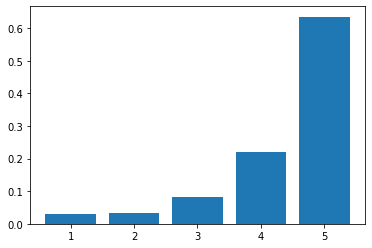

In [32]:
import matplotlib.pyplot as plt
X = [float(r) for r in range(1,6)]
plt.bar(X, [counts[x] for x in X])
plt.show()

In [33]:
torch.arange(1, 0, -0.1)

tensor([1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
        0.1000])

In [34]:
torch.normal(mean=torch.arange(1., 11.), std=torch.arange(1, 0, -0.1))

tensor([1.1915, 2.2976, 3.1845, 4.6255, 4.8774, 5.5460, 6.0755, 8.4906, 9.4123,
        9.9746])

#### 1. How should each class augment

In [35]:
augment_prob = {r: max(1.0 / (len(counts)-1) - c,0.) for r,c in counts.items()}
print(augment_prob)
sum_P = sum(augment_prob.values())
print(sum_P)
all_ratings = [float(r) for r in range(1,6)]
augment_multiplier = {r: augment_prob[r] / (sum_P * counts[r]) for r in all_ratings}
print(augment_multiplier)

{1.0: 0.219253806892479, 2.0: 0.21542793267811194, 3.0: 0.16888893575737124, 4.0: 0.031229172818154988, 5.0: 0.0}
0.6347998481461171
{1.0: 11.233600577502326, 2.0: 9.816119789689461, 3.0: 3.2800788593263976, 4.0: 0.22487141771370195, 5.0: 0.0}


#### 2. Augment with variation

In [36]:
import numpy as np
dist_to_prob = [0.5,0.1,0.03,0.01,0.003]
rating_perturbation_prob = {}
for r in all_ratings:
    P = np.array([dist_to_prob[int(abs(r - r_2))] for r_2 in all_ratings])
    P /= np.sum(P)
    rating_perturbation_prob[r] = P
print(rating_perturbation_prob)
augmented_counts = {r: 0 for r in all_ratings}
augmented_records = []
for record in train_review_data:
    record_rating = record['overall']
    M = augment_multiplier[record_rating]
    remainder = M % 1
    M = int(M)+1 if np.random.random() < remainder else int(M)
    sample_amount = np.random.multinomial(M, rating_perturbation_prob[record_rating])
    for i,n_sample in enumerate(sample_amount):
        for j in range(n_sample):
            new_record = {k:v for k,v in record.items()}
            new_record['overall'] = float(i+1)
            augmented_records.append(new_record)
        augmented_counts[float(i+1)] += n_sample
print(augmented_counts)
print(len(augmented_records))

{1.0: array([0.77760498, 0.155521  , 0.0466563 , 0.0155521 , 0.00466563]), 2.0: array([0.13513514, 0.67567568, 0.13513514, 0.04054054, 0.01351351]), 3.0: array([0.03947368, 0.13157895, 0.65789474, 0.13157895, 0.03947368]), 4.0: array([0.01351351, 0.04054054, 0.13513514, 0.67567568, 0.13513514]), 5.0: array([0.00466563, 0.0155521 , 0.0466563 , 0.155521  , 0.77760498])}
{1.0: 77087, 2.0: 75852, 3.0: 58077, 4.0: 20373, 5.0: 5584}
236973


In [37]:
data_splits['train'] = data_splits['train'] + augmented_records
print(len(data_splits['train']))

474043


In [38]:
save_pickle(data_splits, './{}/rating_splits_augmented.pkl'.format(short_data_name)) # for rating

#### 3. New counts

In [39]:
train_review_data = data_splits['train']

In [40]:
counts = {float(r): 0 for r in range(1,6)}
for record in train_review_data:
    counts[record['overall']] += 1
T = sum(counts.values())
print(T)
for k,c in counts.items():
    counts[k] = float(counts[k])/T
print(counts)

474043
{1.0: 0.1779922918385041, 2.0: 0.1773003714852872, 3.0: 0.16307803300544466, 4.0: 0.15238491022966272, 5.0: 0.32924439344110135}


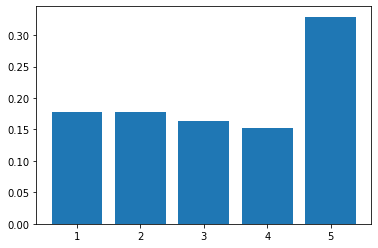

In [41]:
import matplotlib.pyplot as plt
X = [float(r) for r in range(1,6)]
plt.bar(X, [counts[x] for x in X])
plt.show()